# Introduzione a TensorFlow

**TensorFlow** (TF), rilasciato da Google in open source nel 2015, è un framework ad alto livello per lo sviluppo di applicazioni di machine learning, con particolare riguardo verso il [Deep Learning](https://www.nature.com/nature/journal/v521/n7553/full/nature14539.html). 

Come vedremo nei tutorial più avanti, TF permette di costruire (ed allenare) modelli estremamente elaborati, relegando alla macchina alcuni dei compiti più complessi, come il calcolo dei gradienti e l'esecuzione su GPU. In questo tutorial, ci limiteremo ad esplorare l'idea di base di TF, i **grafi computazionali**. Un grafo computazionale è un formalismo immediato che permette di descrivere una serie di operazioni matematiche da svolgere in una certa sequenza:

![Esempio di grafo computazionale in TF](images/tensors_flowing.gif)

Come si vede, l'esecuzione del grafo comincia da uno o più nodi di input, e procede di nodo in nodo fino ai valori più esterni. In questo tutorial, implementeremo un  esempio di regressione lineare tramite grafo computazionale. Prima di questo, iniziamo introducendo tutti gli elementi di base che compongono tali grafi.

## Un primo grafo computazionale

Iniziamo ovviamente importando TF; se non l'avete ancora fatto, installate l'ultima versione della libreria (al momento della scrittura di questo tutorial, la 1.1), seguendo una delle guide ufficiali:
https://www.tensorflow.org/install/

In [1]:
import tensorflow as tf

### Tensori e costanti

Un grafo computazionale definisce una particolare sequenza di operazioni, applicate ad uno o più **tensori**. Per gli scopi di TF, un tensore è semplicemente un insieme di elementi (generalmente numeri reali), ordinati su uno o più dimensioni, con alcune operazioni di base a loro associati.

In 2 dimensioni, ad esempio, un tensore non è altro che la familiare **matrice** dell'algebra lineare: 

$$
A = \begin{bmatrix}
1 & 3 \\
-4 & 5
\end{bmatrix}
$$

Cominciamo definendo proprio questa matrice in TF:

In [2]:
A = tf.constant([[1.0, 3.0], [-4.0, 5.0]])

L'operazione restituisce un oggetto di tipo <code>Tensor</code>, uno degli oggetti di base di TF:

In [3]:
print(A)

Tensor("Const:0", shape=(2, 2), dtype=float32)


Come si può vedere, un tensore è rappresentato da una dimensione (in questo caso, 2x2), e dal tipo dei suoi elementi. L'operazione di prima crea un grafo computazionale con un unico nodo, di tipo **costante**, ovvero il cui valore è preassegnato e non può essere mai modificato. A differenza di quanto avviene lavorando con le classiche matrici in <code>NumPy</code>, non possiamo direttamente accedere al valore del tensore, se non *eseguendo* esplicitamente il grafo.

Possiamo imporre un tipo diverso da quello predefinito passandolo come secondo parametro della funzione:

In [4]:
B = tf.constant([[-0.3, 2], [6, 1/2]], tf.float64)
print(B)

Tensor("Const_1:0", shape=(2, 2), dtype=float64)


### Operazioni su tensori

Nel caso più generale, un grafo computazionale prende in input uno o più dei tensori visti prima, ed esegue su di essi una serie di **operazioni**, il cui ordine è definito da un grafo aciclico. 

Per cominciare, consideriamo una semplice operazione di somma dei nostri due tensori:

In [5]:
C = tf.add(A, tf.cast(B, tf.float32))

Si noti la necessità di convertire B ad una precisione inferiore, per renderlo compatibile con A. Per visualizzare il grafo, installiamo il package [tfgraphviz](https://github.com/akimach/tfgraphviz/blob/master/examples/jupyter_sample.ipynb) da console di comando:

<code>$ pip install tfgraphviz
</code>

Possiamo ora visualizzare il grafo con una semplice istruzione:

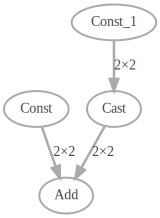

In [6]:
import tfgraphviz as tfg
tfg.board(tf.get_default_graph())

In linea generale, *visualizzare* quello che succede all'interno di TF, il quale lavora su oggetti inerentemente simbolici, è un argomento essenziale, per cui Google ha rilasciato numerosi strumenti, a partire dalla **TensorBoard** fino al debugger ufficiale di TF. Torneremo ripetutamente su questi temi più avanti.

### Input dinamici e variabili

Definire grafi statici è, ovviamente, di interesse limitato. Dopo costanti ed operazioni, il terzo elemento essenziale di un grafo computazionale è un **placeholder**, ovvero un nodo il cui valore non viene assegnato, se non quando il grafo viene effettivamente eseguito.

Riscriviamo il nostro esempio di prima con due variabili; per comodità di visualizzazione, possiamo assegnare a ciascun nodo del grafo un nome:

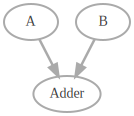

In [7]:
tf.reset_default_graph()
A = tf.placeholder(tf.float32, name='A')
B = tf.placeholder(tf.float32, name='B')
C = tf.add(A, B, name='Adder')
tfg.board(tf.get_default_graph())

Si noti come è necessario resettare il grafo, in modo da rimuovere le operazioni definite in precedenza. In modo più generale, potremmo definire in maniera pragmatica oggetti di tipo <code>Graph</code> su cui aggiungere operazioni, al posto di lavorare sul grafo di default; vedremo un esempio di questo più avanti.

### Eseguiamo il grafo

Una volta definito l'intero grafo computazionale, possiamo eseguire il grafo. Un grafo viene eseguito all'interno di un oggetto che si occupa (tra le altre cose) della sua compilazione e di gestire tutte le risorse del sistema, una **sessione**:

In [8]:
sess = tf.Session()
sess.run([C], feed_dict={A: [1], B: [3]})

[array([ 4.], dtype=float32)]

Come si può vedere, eseguire un grafo equivale a richiedere il valore di uno o più nodi (in questo caso, C), fornendo un valore esplicito per tutti i placeholder del grafo tramite il dizionario <code>feed_dict</code>. 

TF mette anche a disposizione un oggetto più complesso, una <code>InteractiveSession</code>, per rendere più flessibile la fase di definizione del grafo.

# Un esempio più complesso: regressione lineare

## Creazione del dataset

Come esempio preliminare prima di passare alle reti neurali, vediamo una semplice applicazione di TF per un modello di regressione lineare con un dataset 1D. Come primo passo, andiamo a generare un dataset di prova, dove l'output desiderato è dato da una funzione lineare dell'input, ma ciascun esempio è corrotto da rumore di tipo Gaussiano:

In [9]:
# Numero di esempi nel training set
N = 50

# Input campionati casualmente tra [0, 10]
import numpy as np
X = np.random.rand(N)*10

# L'output desiderato è lineare, a meno di un'aggiunta di rumore
y = 0.1*X - 0.3 + 0.1*np.random.randn(N)

Si noti la struttura del **dataset**, che ricorrerà spesso nei tutorial successivi: due matrici, X ed y, corrispondenti a tutte le coppie input/output in nostro possesso, dove ogni riga corrisponde ad un **esempio** specifico. Visualizziamo il nostro dataset di prova con Matplotlib:

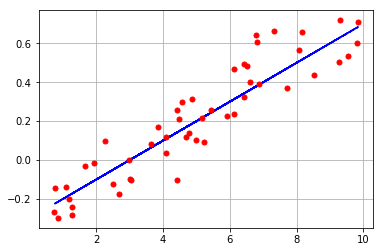

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
plt.plot(X, 0.1*X - 0.3, 'b--', label='Real')
plt.plot(X, y, 'ro', label='Tr. set', markersize=5)
plt.grid()
plt.show()

## Definizione di una funzione obiettivo (cenni)

L'obiettivo della [regressione lineare](https://it.wikipedia.org/wiki/Regressione_lineare) è recuperare i parametri ottimi di un modello lineare (nel nostro caso, 0.1 e -0.3), a partire dai punti osservati (in rosso nella figura di prima).

Per farlo, scegliamo (w,b) di modo che l'**errore quadratico** medio compiuto dal nostro modello sia più piccolo possibile:

$$
J(w,b) = \frac{1}{N}\sum_{i=1}^N (y_i - wx_i - b)^2 \,,
$$

La regressione lineare è uno degli algoritmi più semplici immaginabili per risolvere un problema di machine learning, ma ne racchiude già alcuni degli elementi essenziali:

- La scelta di un modello, in questo caso lineare.
- La definizione di una **funzione obiettivo** $J$, la cui minimizzazione è necessaria per scegliere i parametri ottimi (in questo caso, solamente due).

Per il momento, dedichiamoci a creare un grafo computazionale che descriva tale funzione obiettivo; vedremo in seguito come sfruttare le potenzialità di TF per minimizzarla (in termini tecnici, **ottimizzarla**) e recuperare i parametri ottimi.

## Definire la funzione obiettivo in TF

Per valutare la funzione obiettivo, partiamo dai nostri input/output di training, che (come prima) rappresentiamo con due placeholder:

In [11]:
tf.reset_default_graph()
X_tf = tf.placeholder(tf.float32, name='X_tf')
y_tf = tf.placeholder(tf.float32, name='y_tf')

I parametri del modello (w, b) sono oggetti particolari, di cui dovremo ripetutamente modificare il valore prima di trovare quello ottimale. In generale, tutti i parametri allenabili di un modello devono essere oggetti con uno **stato**, il quale venga aggiornato iterativamente dall'algoritmo scelto per l'ottimizzazione.

Per rappresentarli, l'ultimo elemento essenziale di TF sono le **variabili**:

In [12]:
w = tf.Variable([-0.1], tf.float32, name='w')
b = tf.Variable([-0.1], tf.float32, name='b')

Adesso abbiamo tutti gli elementi per definire il nostro modello lineare:

In [13]:
f = w*X_tf + b

Rimane solo da definire la funzione obiettivo: per farlo, calcoliamo tutti gli errori compiuti dal nostro modello, li eleviamo al quadrato, e ne calcoliamo la media con la funzione <code>reduce_mean</code>:

In [14]:
e = y_tf - f
J = tf.reduce_mean(tf.square(e))

Come prima, andiamo a visualizzare il grafo computazionale così ottenuto:

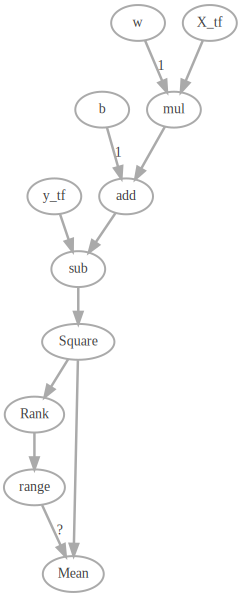

In [15]:
import tfgraphviz as tfg
tfg.board(tf.get_default_graph())

Si noti come alcune operazioni di base di TF (es., <code>reduce_mean</code>) corrispondono a diversi nodi nel grafo computazionale. Tale grafo inizia ad essere di difficile lettura: vedremo più avanti come affrontare questo problema.

## Ottimizzare una funzione obiettivo (cenni)

Chi ha già avuto a che fare con modelli di regressione lineare, sa che in questo caso molto semplice è possibile calcolare i parametri ottimi del modello in forma chiusa. Questo, però, non rimane vero per modelli più complessi quali le reti neurali. Essendo le reti neurali il nostro vero obiettivo, introduciamo quindi un metodo più generale.

Nel caso in cui la funzione obiettivo non sia risolvibile in forma chiusa, è necessario applicare algoritmi numerici (iterativi) a tal fine. Per funzioni differenziabili, il più famoso di essi è la [discesa al gradiente](https://it.wikipedia.org/wiki/Discesa_del_gradiente), che cerca di avvicinarsi sequenzialmente all'ottimo scegliendo in ogni momento una direzione lungo la quale la funzione obiettivo migliora, ovvero decresce. 

Un risultato essenziale nell'ottimizzazione numerica è che tale direzione si può trovare scegliendo continuamente la direzione opposta alla derivata della funzione costo rispetto alla nostra stima corrente:

$$
w \leftarrow w - \alpha \frac{dJ}{dw}
$$

$$
b \leftarrow b - \alpha \frac{dJ}{db}
$$

Il parametro $\alpha$, detto *learning rate* o *step size*, definisce quanto 'muoversi' ad ogni iterazione: un $\alpha$ troppo alto porta ad instabilità, mentre un $\alpha$ troppo basso porta ad un processo di ottimizzazione molto lento. Nel caso in cui $w$ sia un vettore di parametri, l'equazione di prima rimane valida sostituendo la derivata con il **gradiente**, un vettore che colleziona tutte le derivate parziali rispetto a ciascun parametro.

In pratica, è possibile utilizzare un sottoinsieme di dati ad ogni iterazione per ridurre il costo computazionale di calcolare il gradiente. In questo caso, si parla di ottimizzazione **stocastica**. E' anche possibile velocizzare questo algoritmo di base in diversi modi: vedremo esempi di entrambe queste idee successivamente.

## Ottimizzazione in TensorFlow

Uno degli aspetti essenziali di TF è la possibilità di calcolare in maniera **automatica** il gradiente di ciascun nodo del grafo computazionale, relativamente a qualsiasi altro nodo. Oltre a questo, TF mette a disposizione nel modulo <code>train</code> alcuni algoritmi di ottimizzazione già implementati per ottimizzare le funzioni costo.

Ad esempio, inizializziamo una semplice discesa al gradiente come quella vista prima, con un $\alpha$ pari a $0.01$:

In [16]:
optimizer = tf.train.GradientDescentOptimizer(0.01)
train = optimizer.minimize(J)

Nel caso in cui il grafo computazionale contenga variabili, è necessario inizializzarle in maniera esplicita prima di eseguire il grafo. TF mette a disposizione una funzione di default per inizializzare *tutte* le variabili del grafo:

In [17]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

I valori dell'inizializzazione sono stati forniti al momento della definizione delle variabili. A questo punto, eseguiamo il processo di ottimizzazione per 1000 iterazioni:

In [18]:
for i in range(1000):
  sess.run(train, feed_dict={X_tf: X, y_tf: y})

Ispezionando i valori delle variabili, troveremo quindi il loro nuovo valore, che si avvicina a quello desiderato:

In [19]:
print('w: ', w.eval(session=sess), 'b: ', b.eval(session=sess))

w:  [ 0.10349116] b:  [-0.30584168]


<code>eval</code> è una funzione di comodo per valutare tensori il cui valore non dipende da nessun placeholder. Possiamo anche stampare l'errore quadratico medio compiuto dal modello:

In [20]:
print('J: ', sess.run(J, feed_dict={X_tf: X, y_tf: y}))

J:  0.0123252


Continuando il processo di ottimizzazione con uno step size più piccolo, potremmo arrivare ad un errore medio arbitrariamente vicino a 0. Mentre in questo caso non sarebbe un problema, in generale questo non è desiderabile a causa dell'**overfitting**, la tendenza di modelli molto complessi (come le reti neurali) ad adattarsi in maniera eccessiva ai dati di training, peggiorando la loro accuratezza su dati futuri. Torneremo su questo punto in seguito.

Per oralcoliamo i valori predetti dal nostro modello sui punti di training:

In [21]:
y_pred = sess.run(f, feed_dict={X_tf: X})

Concludiamo visualizzando la funzione ottenuta:

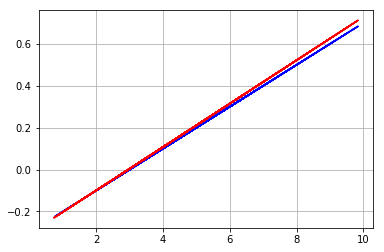

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
plt.plot(X, 0.1*X - 0.3, 'b--', label='Real')
plt.plot(X, y_pred, 'red', label='Predicted')
plt.grid()
plt.show()

Siamo pronti a muoverci verso le reti neurali!